<a href="https://colab.research.google.com/github/Fsayes/Proyecto_DS_Factores_Asfixia_Parto/blob/main/Desaf%C3%ADo_12_Pre_Entrega_II_Fabian_Sayes_Sayes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Identificación de factores que predicen el riesgo de asfixia en el parto.**

## **1. Datos Generales.**
El hospital San Juan San de Dios, es el primer hospital público de Chile y está ubicado en la ciudad de Santiago , es un establecimiento de salud de alta complejidad cuya atención alcanza una población estimada de más de 1 millón 300 mil personas provenientes de 15  comunas del sector occidente de la Región Metropolitana (urbanas y rurales), formando parte de  de la red del Servicio de Salud Occidente de Santiago, Recibiendo derivaciones de 7 hospitales de mediana y baja complejidad de la red de salud.

El foco de este trabajo, estará en la seeción de Partos de la unidad de Gineco-Obstetricia.

## **2. Dataset.**
El dataset original proporcionado por la institución está en formato Excel con datos agrupados, tanto de información de la madre (Edad, Peso, IMC, Partos Anteriores), como del bebé (Edad Gestacional, Peso, talla), así como también datos sobre el tratamiento y tipo de parto que se realizó. Toda la información corresponde al año 2023.

***Actualización***, los datos ha partir de esta entrega corresponde a los años 2021, 2022 y 2023.

## **3. Definición de la temática.**
De acuerdo con lo mencionado en los puntos anteriores, el foco de este trabajo estará en el trabajo realizado por la sección de parto del hospital, buscando la relación que existe entre los antecedentes de la madre, el bebé y los tratamientos previos al parto con el riesgo de asfixia durante el nacimiento.

> **3.1 Hipotesis**: Existen factores que permiten identificar el riesgo de asfixia durante el parto.

> **3.2 Objetivo Principal**: Otorgar a los y las profesionales clínicos una herramienta que logre calcular el riesgo de axfisia del bebé por nacer, les permita definir el tipo de part0 que minimice de mejor forma ese riesgo.

> **3.2 Objetivos Especificos**:

>>a) Determinar cuales son las variables, asociadas a la madre y al bebé, que tienen mayor relación con los apgar iguales o menores a 3 (asfixias), tanto al minuto de nacido como a los 5 minutos del nacimiento.

>>b) Identificar si existen prácticas clínicas que aumenten el riesgo de asfixia, tales como maduración, inducción de partos a madres con cesareas anteriores.

> **3.3 Usuarios Finales**: Este trabajo está destinado a Medicos y Matronas del área.

> **3.4- Líneas futura**: Este informe se puede ampliar con nuevos criterios de medida, se debe actualizar con nuevos datos, para así tener un panorama más amplio de la actividad desarrollada.





# 4. Elección del dataset
Se trabajará con un dataset otorgado por la institución que contiene la información de cada parto atendido durante 2023. Entre las variables podemos encontrar:



*   Edad de la Madre
*   Peso de la Madre
*   Talla de la Madre
*   IMC de la Madre
*   Edad gestacional
*   Talla y peso del bebé
*   Apgar1 (corresponde al estado del bebé al minuto de nacido)
*   Apgar5 (corresponde al estado del bebé a los 5 minutos de nacido)

A considerar: Apgar igual o menor que 3 corresponde a asfixia del recién nacido


**4.1 Preparación:** Carga de librerias, montaje de drive y lectura del archivo xlsx original.

In [1]:
# 1. cargar librerias
import pandas                  as pd
import scipy
from   scipy import stats
import numpy                   as np
import matplotlib.pyplot       as plt
import seaborn                 as sns
import statsmodels.api as sm
import os
from sklearn import linear_model
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from ast import Lambda
from sklearn.datasets import load_digits
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import LearningCurveDisplay, ShuffleSplit

# 2. Montar google drive
from google.colab import drive
import os
drive.mount('/content/drive')
ruta_archivos = '/content/drive/MyDrive/Datasets_Estudio'


Mounted at /content/drive


In [2]:
# Lectura de los archivos de parto original

# Lista para almacenar DataFrame Nómina
dataframes_partos = []

# Iterar sobre los archivos en el directorio
for archivo_xlsx in os.listdir(ruta_archivos):
    if 'partos' in archivo_xlsx and archivo_xlsx.endswith(".xlsx"):
        # Construir la ruta completa del archivo
        ruta_completa = os.path.join(ruta_archivos, archivo_xlsx)

        # Leer el archivo CSV y agregarlo a la lista de DataFrames
        df = pd.read_excel(ruta_completa, skiprows=0)
        dataframes_partos.append(df)

# Concatenar todos los DataFrames en uno solo
df_partos = pd.concat(dataframes_partos, ignore_index=True)

**4.2 Exploración del dataset y Data Wrangling:** Se analiza la composición del dataset, luego se ordena y transforma ajustando a la necesidad del proyecto

In [3]:
# Revisión de los tipos de los campos del dataset
df_partos.dtypes

Fecha_Parto           object
Hora_Parto            object
Nombre_Paciente       object
Apellidos_Paciente    object
Edad                  object
                       ...  
Responsable_Ai        object
Desgarro              object
Causa_Cesárea         object
Parto_Precipitado     object
Acompañante.1         object
Length: 61, dtype: object

**Revisión de Duplicados:**
Nuestro Dataset no presenta Duplicados

In [4]:
# Búsqueda de duplicados
# Paso 1 vemos la forma del dataset
print(df_partos.shape)

# Paso 2 creamos una sentencia que elimine los duplicados
df_partos = df_partos.drop_duplicates()

# Paso 3 volvemos a verificar laa forma del dataset
print(df_partos.shape)

(8009, 61)
(8007, 61)


**Revisión de valores Nulos:** Al verificar si existen valores nulos en nuestro dataset, nos damos cuenta que las columnas Apgar 1 y Apgar 5 si tienes nulos, por lo que los corregimos imputando el promedio.

In [5]:
# verificamos que campos poseen registros nulos
nulos = df_partos.isnull().sum()
for index, value in nulos.items():
    print(f"{index}: {value}")

Fecha_Parto: 0
Hora_Parto: 0
Nombre_Paciente: 1
Apellidos_Paciente: 0
Edad: 0
Rut: 129
Nacionalidad: 0
Peso_Madre: 0
Talla_Madre: 0
IMC_Madre: 0
Consultorio: 0
Edad_Gestacional: 0
Tto_Alternativo: 0
Tipo_Parto: 0
Episiotomia: 0
Sutura: 0
Revision: 0
Anestesia: 0
Paridad: 0
Hrs_T_Parto: 0
Induccion: 0
Conduccion: 0
Nro_Comprobante: 8007
Estado: 0
Sexo: 0
Peso_Bebe: 0
Talla_Bebe: 0
Circ_Craneana: 0
Apgar1: 31
Apgar5: 28
Malformacion: 7871
Min_Apego: 0
Acompañante: 0
Reanimacion: 0
Examenes: 1447
Edad_Pediatrica: 0
Diagnostico: 0
Neonatologo: 0
Maduracion: 0
Destino: 76
Clasificación_Robson: 0
Visita_a_la_Maternidad: 0
Monitorización: 6870
Parto_En_Domicilio: 6870
N°_De_Tactos_vaginales: 6870
Régimen_hídrico_amplio: 6870
Óxido_Nitroso: 6870
Oxitocina_Profiláctica: 6870
Etnia: 0
Lactancia_Materna_en_los_primeros_60_minutos_de_vida: 0
Retirará_Placenta: 0
Al_menos_1_VIH_en_control_de_Embarazo: 0
VIH_en_el_Parto: 0
¿Porque_no_se_toma_VIH?: 5311
N°_de_comprobante_de_partos: 1501
Responsable_P

In [6]:
# definimos promedios de Apgar1 y Apgar5
avg_apgar1 = df_partos['Apgar1'].mean()
avg_apgar5 = df_partos['Apgar5'].mean()

# Rellenamos los vacios con el promedio
df_partos['Apgar1'].fillna(avg_apgar1, inplace = True)
df_partos['Apgar5'].fillna(avg_apgar5, inplace = True)

# verificamos si aun quedan nulos
null_values_Apgar1 = df_partos['Apgar1'].isnull().sum()
null_values_Apgar5 = df_partos['Apgar5'].isnull().sum()

print(f"Apgar1: {null_values_Apgar1}")
print(f"Apgar5: {null_values_Apgar5}")

Apgar1: 0
Apgar5: 0


**Transformación de datos:** Se transforma el tipo de algunas columnas que son útiles para el analisis objetivo del proyecto y se eliminan otras poco relevantes para el estudio.

In [7]:
# Convertimos la columna fecha a tipo fecha y extraemos el mes
df_partos['Fecha_Parto']= pd.to_datetime(df_partos['Fecha_Parto'],dayfirst=True)
df_partos['Mes']= df_partos['Fecha_Parto'].dt.strftime('%m')

# Extraemos el Año en una nueva columna
df_partos['Año'] = df_partos['Fecha_Parto'].dt.strftime('%Y')

In [8]:
# Crear una columna con el mínimo de apgar entre Apgar1 y Apgar5
df_partos["Min_Apgar"] = df_partos[["Apgar1", "Apgar5"]].min(axis=1)

# Agrega una columna con el dato binario para las asfixias 1 para si y 0 para no
df_partos['Asfixia'] = df_partos['Min_Apgar'].apply(lambda x: 1 if x <= 3 else 0)

In [9]:
# Agregar una columna que indique si el menor valor es de la columna "Apgar1" o de la columna "Apgar5"
df_partos["Tiempo_min_Apgar"] = df_partos[["Apgar1", "Apgar5"]].idxmin(axis=1)

In [10]:
# Eliminamos la Palabra años del campo edad y lo transformamos a tipo de número entero, ya que este dato puede ser relevante para el estudio
df_partos['Edad'] = df_partos['Edad'].str.replace(' años','').astype(int)

In [11]:
# modifica el dato del campo conducción a un dato binario si = 1 y no = 0
df_partos['Conduccion'] = df_partos['Conduccion'].map({'Si':1,'No':0})

In [12]:
# modifica el dato del campo inducción a un dato binario si = 1 y no = 0
df_partos['Induccion'] = df_partos['Induccion'].apply(lambda x: 0 if x == 'no' else 1)

In [13]:
# modifica el dato del campo Tratamiento Alternativo a un dato binario si = 1 y no = 0
df_partos['Tto_Alternativo'] = df_partos['Tto_Alternativo'].apply(lambda x: 0 if x == 'No' else 1)

In [14]:
columnas_eliminar=['Nombre_Paciente','Apellidos_Paciente','Rut','Fecha_Parto','Hora_Parto']
df_partos = df_partos.drop(columnas_eliminar,axis=1)

In [15]:
df_partos.head(5)

,Edad,Nacionalidad,Peso_Madre,Talla_Madre,IMC_Madre,Consultorio,Edad_Gestacional,Tto_Alternativo,Tipo_Parto,Episiotomia,...,Responsable_Ai,Desgarro,Causa_Cesárea,Parto_Precipitado,Acompañante.1,Mes,Año,Min_Apgar,Asfixia,Tiempo_min_Apgar
0,28,CHILE,69.0,1.70,23.9,Hospital Adalberto Steeger (Talagante),39,1,Normal-45,No,...,KATHY ALEJANDRA OLEA MORALES - -,g1,No Aplica,No,No,01,2021,9.0,0,Apgar1
1,23,CHILE,128.0,1.63,48.2,Centro de Salud Familiar Violeta Parra,40,1,Cesarea-Urgencia,No,...,NAZARETH PATRICIA HUERTA GUARDIA - -,No,EFNT,No,Si,01,2021,8.0,0,Apgar1
2,17,CHILE,57.0,1.60,22.3,Centro de Salud Familiar Dr. Raul Yazigi,37,1,Normal-Litotomia,g1,...,NAZARETH PATRICIA HUERTA GUARDIA - -,No,No Aplica,No,Si,01,2021,2.0,1,Apgar1
3,24,CHILE,64.0,1.59,25.3,Centro de Salud Familiar Violeta Parra,41,1,Normal-45,No,...,NAZARETH PATRICIA HUERTA GUARDIA - -,g1,No Aplica,No,Si,01,2021,9.0,0,Apgar1
4,32,CHILE,79.0,1.59,31.2,Consultorio Pudahuel Estrella,36,0,Normal-45,No,...,FELIPE SALAZAR URRA - -,No,No Aplica,No,No,02,2021,8.0,0,Apgar1


# **5. Análisis Exploratorio**

En esta sección se extraeran los primeros insights de los datos contenidos en el dataset, se evaluará que información puede ser relevante para conseguir el objetivo de conocer las variables que nos pueden ayudar a identificar el riesgo de asfixia en los primeros 5 minutos del nacimiento.

## **5.1 Resumen de partos por mes**:
 En este gráfico, podemos ver un resumen de la cantidad total de partos mensuales atendidos en la maternidad del hospital San Juan de Dios de Santiago de Chile.

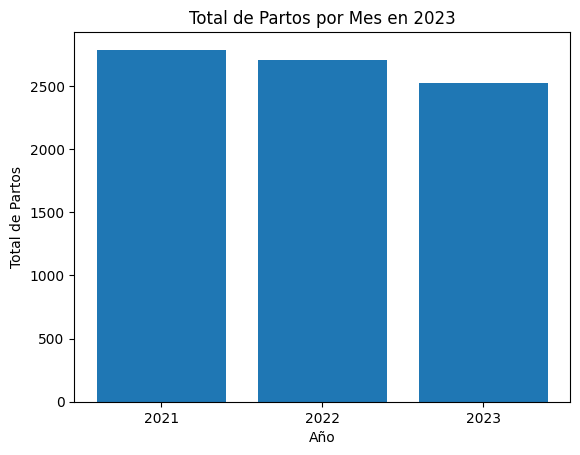

In [16]:
# Crea resumen de partos por mes
partos_mes = df_partos.groupby('Año').size().reset_index(name='partos')

# Con Matplotlib
fig, ax = plt.subplots()
ax.bar(partos_mes['Año'], partos_mes['partos'])
ax.set_xlabel('Año')
ax.set_ylabel('Total de Partos')
ax.set_title('Total de Partos por Mes en 2023')
plt.show()

**Tabla Resumen de Partos y Asfixias por Mes:** en esta tabla se puede apreciar cuantos de estos partos presentan asfixias en los primeros 5 minutos desde el alumbramiento.


In [17]:
# Creamos un df resumen por mes con el total de partos y cuantas asfixias hubieron
df_resumen = df_partos.groupby('Año').agg({'Mes': 'count', 'Asfixia': 'sum'})

# Renombramos las columnas para que sean más descriptivas
df_resumen.columns = ['Cantidad de Partos', 'Cantidad de Asfixias']

# Agregamos una columna para calcular % de asfixias por mes
df_resumen['porc_asfixias'] = round((df_resumen['Cantidad de Asfixias']/df_resumen['Cantidad de Partos'])*100,2)

print(df_resumen)

      Cantidad de Partos  Cantidad de Asfixias  porc_asfixias
Año                                                          
2021                2786                    78           2.80
2022                2702                    93           3.44
2023                2519                    85           3.37


**Datos Promedio:** Con base en la tabla anterior podemos conocer que en promedio, la maternidad del Hospital San Juan de Dios atiende 210 partos al mes, de estos en promedio 7 presentan asfixia dentro de los primeros 5 minutos del nacimiento, lo que implica un 3,41% de nacimientos con asfixia.

In [49]:
# Calculamos el promedio mensual de partos en que hay asfixias
avg_asfixias = round(df_resumen['Cantidad de Asfixias'].mean(),0)

# Calcula el promedio de partos
avg_partos = round(df_resumen['Cantidad de Partos'].mean(),0)

# Calculamos el % promedio mensual de partos en que hay asfixias
avg_porc_asfixias = round(df_resumen['porc_asfixias'].mean(),2)

print(f"El promedio de partos por año es {avg_partos:.2f}.")
print(f"El número promedio de partos que presentan asfixias en un año es {avg_asfixias:.2f}.")
print(f"El porcentaje promedio de los partos que presentan asfixia dentro de los primeros 5 minutos es de un {avg_porc_asfixias}%.")

El promedio de partos por año es 2669.00.
El número promedio de partos que presentan asfixias en un año es 85.00.
El porcentaje promedio de los partos que presentan asfixia dentro de los primeros 5 minutos es de un 3.2%.


**Número de recién nacidos que sufren asfixia**: En este gráfico podemos el total de recien nacidos que sufrieron asfixia, separado según la clasificación apgar.

Las asfixias representan un 3.2% del total de partos


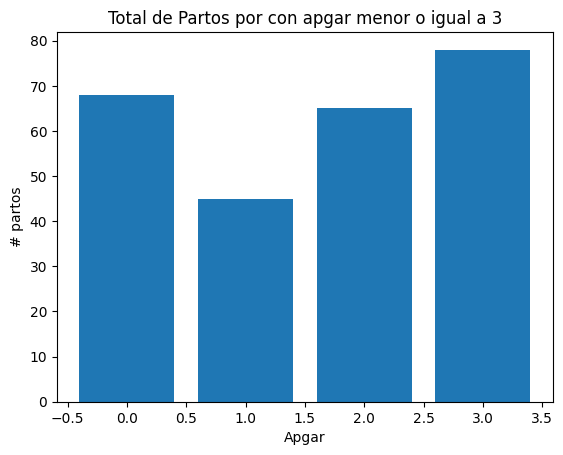

In [19]:
# Crea un DF filtrado para valores de apgar menor o igual a 3
df_asfixias = df_partos[df_partos['Min_Apgar'] <=3]

# Saca columnas con datos no relevantes para el analisis
columnas_eliminar_1=['Nro_Comprobante','Apgar1', 'Apgar5']
df_asfixias = df_asfixias.drop(columnas_eliminar_1,axis=1)

# Crea resumen por Apgar Mínimo
Apgar_min = df_asfixias.groupby('Min_Apgar').size().reset_index(name='partos')

# Calcula el total de asfixias de la muestra
suma_asfx = Apgar_min['partos'].sum()

# Calcula el total de partos
suma_partos = partos_mes['partos'].sum()

# Calcula el porcentaje de asfixias
porc_asfixias = round((suma_asfx/suma_partos)*100,2)

# Muestra el resultado
print(f"Las asfixias representan un {porc_asfixias}% del total de partos")

# Con Matplotlib
fig, ax = plt.subplots()
ax.bar(Apgar_min['Min_Apgar'], Apgar_min['partos'])
ax.set_xlabel('Apgar')
ax.set_ylabel('# partos')
ax.set_title('Total de Partos por con apgar menor o igual a 3')
plt.show()

## **5.2 Análisis Univariado:**
A continuación se realizará el analisis individual de algunas de las variables, que los profesionales del Hospital San Juan de Dios han mencionado como importantes a la hora de "Intuir" si un bebé tiene riesgo de asfixia al momento del parto.  

**5.2.1 Edad de la Madre:** En los casos en que hubo asfixia en el nacimiento, Las edades de las madres 5 a 44 años con un promedio de 29.4 años en una muestra de 256 partos con asfixia. La varianza de 42.2 indica una dispersión moderada en las edades. La asimetría positiva sugiere más madres jóvenes, y la curtosis negativa indica la presencia de edades extremas.

DescribeResult(nobs=256, minmax=(15, 44), mean=29.39453125, variance=42.21628370098039, skewness=0.28136433550318934, kurtosis=-0.575450955329865)

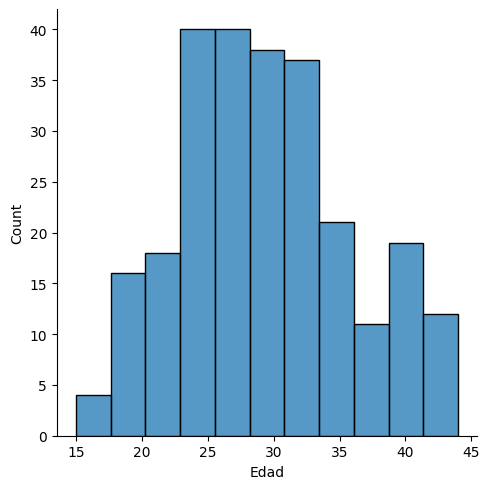

In [20]:
sns.displot(df_asfixias['Edad'], kde=False)
scipy.stats.describe(df_asfixias['Edad'])

**5.2.2 Edad gestacional:** La edad gestacional en la muestra varía de 19 a 41 semanas con un promedio de 32.9 semanas en 256 partos con asfixia. La varianza de 33.1 indica una dispersión moderada. La asimetría negativa sugiere más bebés con mayor edad gestacional, y la curtosis negativa indica una distribución menos concentrada alrededor de la media.

DescribeResult(nobs=256, minmax=(19, 41), mean=32.94140625, variance=33.137729779411764, skewness=-0.49075980612469644, kurtosis=-1.0169049949110696)

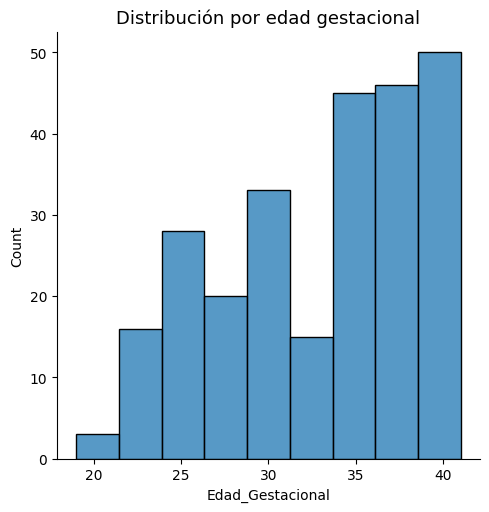

In [21]:
sns.displot(df_asfixias['Edad_Gestacional'], kde=False)
plt.title('Distribución por edad gestacional', fontsize=13)
scipy.stats.describe(df_asfixias['Edad_Gestacional'])

**5.2.3 Talla de Madres:** La talla de las madres en la muestra varía de 1.36 a 1.79 metros con un promedio de 1.59 metros en 256 partos con asfixia. La varianza de 0.004 indica una dispersión baja. La asimetría positiva sugiere una ligera prevalencia de madres más altas, y la curtosis positiva indica una distribución más concentrada alrededor de la media.

DescribeResult(nobs=256, minmax=(1.36, 1.79), mean=1.59125, variance=0.003996862745098036, skewness=0.25323979719740625, kurtosis=0.6814682430151171)

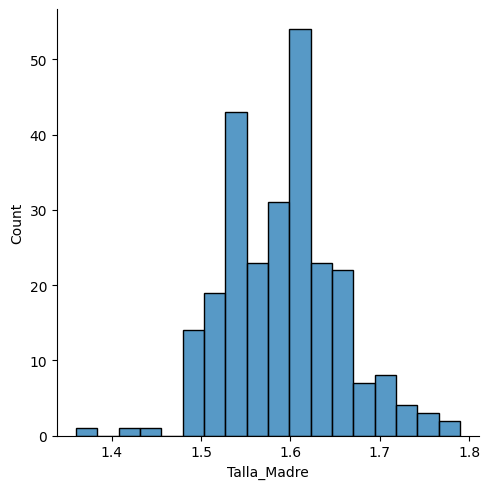

In [22]:
sns.displot(df_asfixias['Talla_Madre'], kde=False)
scipy.stats.describe(df_asfixias['Talla_Madre'])

**5.2.4 Peso de la Madre:** El peso de las madres en la muestra varía de 48 a 147 kg con un promedio de 81.46 kg en 256 partos con asfixia. La varianza de 305.24 indica una dispersión alta. La asimetría positiva sugiere una ligera prevalencia de madres con mayor peso, y la curtosis cercana a cero indica una distribución normal alrededor de la media.

DescribeResult(nobs=256, minmax=(48.0, 147.0), mean=81.4640625, variance=305.24270343137255, skewness=0.4319920470592424, kurtosis=0.04964212319598715)

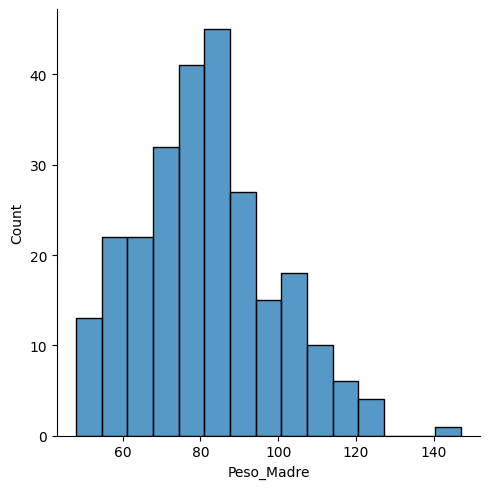

In [23]:
sns.displot(df_asfixias['Peso_Madre'], kde=False)
scipy.stats.describe(df_asfixias['Peso_Madre'])

**5.2.5 Peso del Bebé:** El peso de los bebés en la muestra varía de 200 a 4555 gramos con un promedio de 2149.46 gramos en 256 partos con asfixia. La varianza de 1349891.49 indica una dispersión alta. La asimetría cercana a cero sugiere una distribución simétrica del peso, y la curtosis negativa indica una distribución menos concentrada alrededor de la media y colas más ligeras que una distribución normal.



DescribeResult(nobs=256, minmax=(200, 4555), mean=2149.4609375, variance=1349891.4886642157, skewness=0.02559580929361562, kurtosis=-1.2503974858325066)

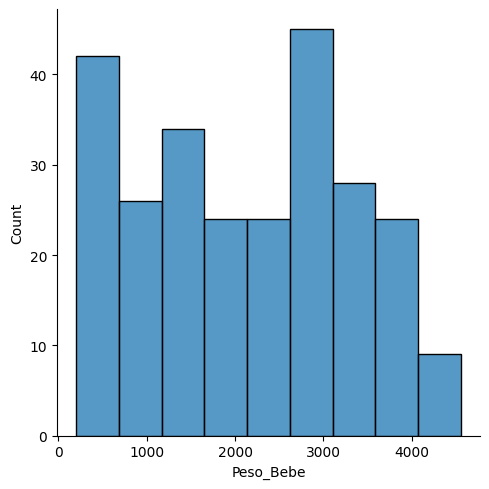

In [24]:
sns.displot(df_asfixias['Peso_Bebe'], kde=False)
scipy.stats.describe(df_asfixias['Peso_Bebe'])

**5.2.5 Talla del Bebé:** La talla de los bebés en la muestra varía de 11 a 55 cm con un promedio de 42.05 cm en 256 partos con asfixia. La varianza de 63.79 indica una dispersión moderada. La asimetría negativa sugiere una ligera prevalencia de bebés más largos, y la curtosis cercana a cero indica una distribución casi normal alrededor de la media.

DescribeResult(nobs=256, minmax=(11.0, 55.0), mean=42.05078125, variance=63.78956801470588, skewness=-0.7056706976317183, kurtosis=-0.2517563052316367)

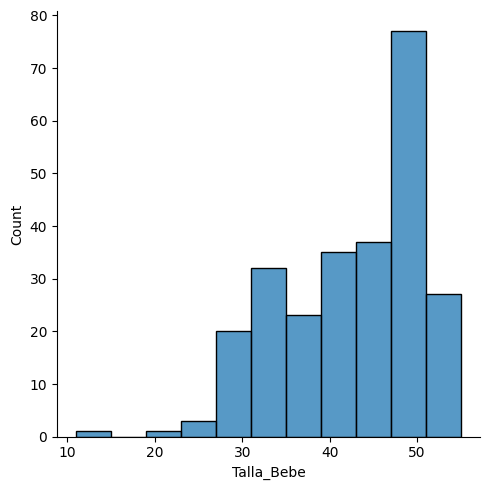

In [25]:
sns.displot(df_asfixias['Talla_Bebe'], kde=False)
scipy.stats.describe(df_asfixias['Talla_Bebe'])

**5.2.6 Aplicación de Tratamientos Alternativos:** Se puede apreciar que en 2 de cada 3 partos en los que hubo asfixia, no se realizó ningún tratamiento alternativo, como uso de balón kinésico, aromaterapia o musicoterapia.

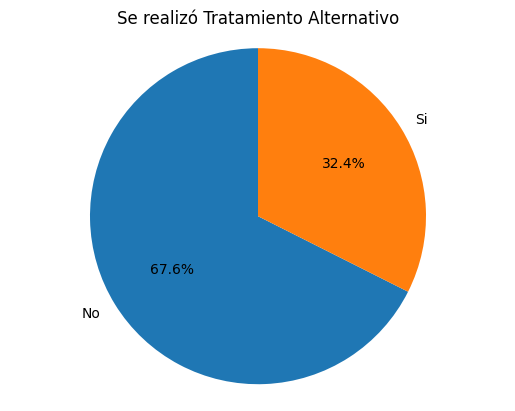

In [26]:
# Crea resumen por Apgar Mínimo
Tratamiento = df_asfixias.groupby('Tto_Alternativo').size().reset_index(name='partos')
# modifica el dato del campo Tratamiento Alternativo a un dato de si o no
Tratamiento['Tto_Alternativo'] = Tratamiento['Tto_Alternativo'].apply(lambda x: 'No' if x == 0 else 'Si')
# Con Matplotlib
fig, ax = plt.subplots()
ax.pie(Tratamiento['partos'], labels=Tratamiento['Tto_Alternativo'], autopct='%1.1f%%', startangle=90)
ax.axis('equal')  # Asegura que se dibuje como un círculo.
ax.set_title('Se realizó Tratamiento Alternativo')
plt.show()

**5.2.6 Conducción del parto:** En el 87% de los partos con asfixia, no se condujo, es decir que no se aplicó oxitocina o rotura artificial de membrana.

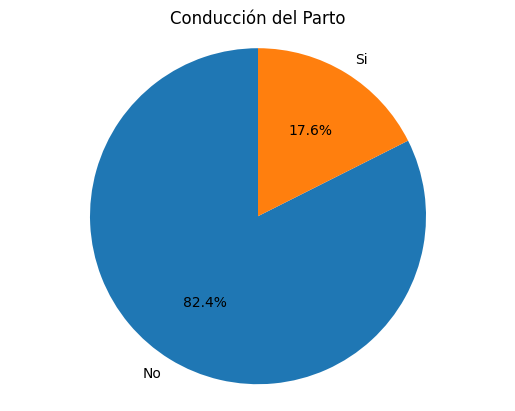

In [27]:
# Crea resumen por Apgar Mínimo
Conduccion = df_asfixias.groupby('Conduccion').size().reset_index(name='partos')
# modifica el dato del campo Tratamiento Alternativo a un dato de si o no
Conduccion['Conduccion'] = Conduccion['Conduccion'].apply(lambda x: 'No' if x == 0 else 'Si')
# Con Matplotlib
fig, ax = plt.subplots()
ax.pie(Conduccion['partos'], labels=Conduccion['Conduccion'], autopct='%1.1f%%', startangle=90)
ax.axis('equal')  # Asegura que se dibuje como un círculo.
ax.set_title('Conducción del Parto')
plt.show()

## **5.3 Análisis Bivariado:**
En la siguiente sección se analizará la posible relación entre las distintas variables del dataset.

**5.3.1 Relación entre edad gestacional y peso del bebé**: A partir de este gráfico, parece haber una tendencia general creciente en el peso mediano del bebé a medida que aumenta la edad gestacional, lo que sugiere una correlación positiva entre estas dos variables.

Además, la variabilidad en los pesos en diferentes etapas del embarazo, incluyendo posibles valores atípicos, también es notable. Esto podría indicar que otros factores además de la edad gestacional pueden estar influyendo en el peso del bebé.

<Axes: xlabel='Edad_Gestacional', ylabel='Peso_Bebe'>

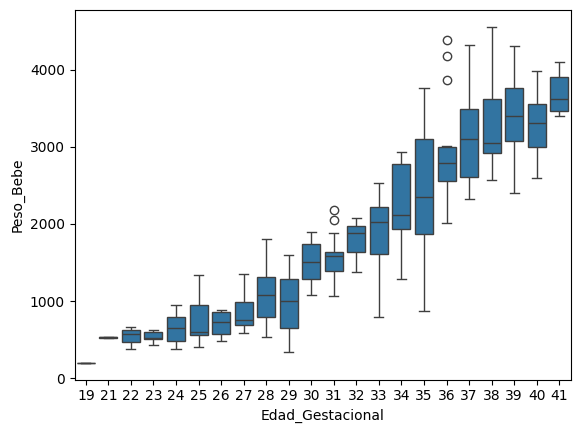

In [28]:
# Con seaborn
sns.boxplot(x=df_asfixias['Edad_Gestacional'], y=df_asfixias['Peso_Bebe'])

**5.3.2 Relación entre Peso del Bebé y Clasificicación Apgar**: En el diagrama de dispersión siguiente, cada punto representa un dato individual que corresponde al peso de un bebé y su puntuación de Apgar. No hay una tendencia o correlación clara visible en la distribución de los puntos a través del gráfico; están ampliamente dispersos sin formar ningún patrón distintivo o linealidad entre las dos variables.

<Axes: xlabel='Min_Apgar', ylabel='Peso_Bebe'>

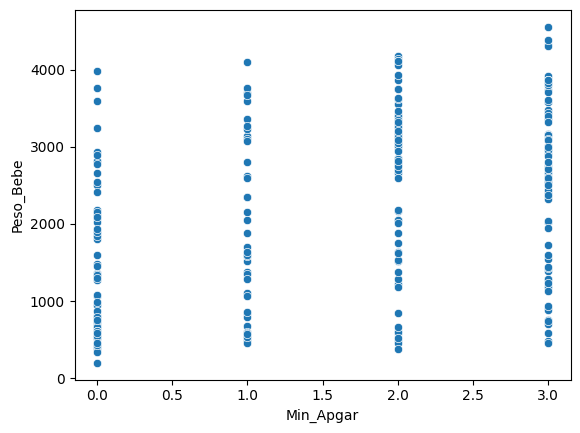

In [29]:
# Gráfica de apgar al minuto de nacido y pesó bebé
sns.scatterplot(x=df_asfixias['Min_Apgar'], y=df_asfixias['Peso_Bebe'])

**5.3.3 Relación entre edad gestacional y Clasificación Apgar**: El gráfico sugiere una relación entre las puntuaciones mínimas de Apgar y la edad gestacional. Parece que a medida que la clasificación Apgar aumenta de 0 a 3, hay menos variabilidad en la edad gestacional, como lo indican las cajas y los bigotes más cortos.

<Axes: xlabel='Min_Apgar', ylabel='Edad_Gestacional'>

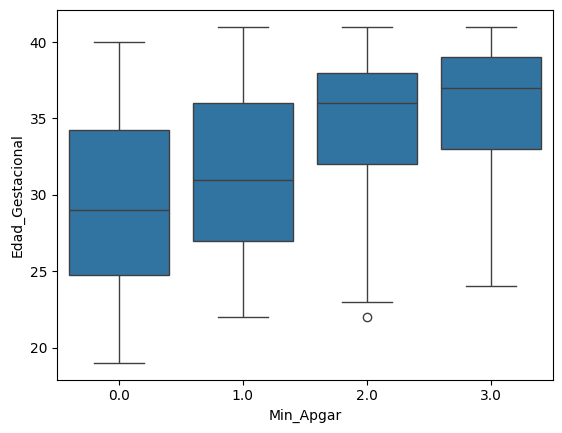

In [30]:
# Gráfica de apgar minimo y Edad Gestacional
sns.boxplot(x=df_asfixias['Min_Apgar'], y=df_asfixias['Edad_Gestacional'])

## **5.4 Matriz de Correlación entre las variables**:
En la siguiente gráfica se puede apreciar la correlación entre las distintas variables. Para esto se consideraron solo las variables que se pueden conocer antes del parto, ya que nuestro objetivo es poder predecir el riesgo de asfixia presente en el parto.

In [31]:
#Crea una copia del dataframe df_partos, eliminando las variables que solo se pueden conocer luego del parto y las que solo son informativas
columnas_eliminar1=['Nacionalidad','Consultorio','Tipo_Parto','Tto_Alternativo','Episiotomia','Sutura','Revision','Anestesia','Nro_Comprobante','Estado','Sexo', 'Clasificación_Robson', 'Visita_a_la_Maternidad','Monitorización', 'Parto_En_Domicilio','Régimen_hídrico_amplio', 'Óxido_Nitroso',
       'Oxitocina_Profiláctica','Etnia', 'Lactancia_Materna_en_los_primeros_60_minutos_de_vida','Retirará_Placenta', 'Al_menos_1_VIH_en_control_de_Embarazo','VIH_en_el_Parto', '¿Porque_no_se_toma_VIH?','N°_de_comprobante_de_partos', 'Responsable_Parto', 'Responsable_Ai','Desgarro', 'Causa_Cesárea',
       'Parto_Precipitado', 'Acompañante.1','Mes','Min_Apgar','Tiempo_min_Apgar','Apgar1', 'Apgar5', 'Malformacion','Min_Apego', 'Acompañante', 'Reanimacion', 'Examenes','Neonatologo', 'Maduracion', 'Destino','Diagnostico','N°_De_Tactos_vaginales','Edad_Pediatrica','Año']

df_partos_modelo = df_partos.drop(columnas_eliminar1,axis=1)
df_partos_modelo.head()

,Edad,Peso_Madre,Talla_Madre,IMC_Madre,Edad_Gestacional,Paridad,Hrs_T_Parto,Induccion,Conduccion,Peso_Bebe,Talla_Bebe,Circ_Craneana,Asfixia
0,28,69.0,1.70,23.9,39,0,6,0,0,3280,49.0,34.0,0
1,23,128.0,1.63,48.2,40,1,12,1,0,3535,51.0,34.0,0
2,17,57.0,1.60,22.3,37,0,20,1,1,2810,48.0,35.0,1
3,24,64.0,1.59,25.3,41,1,5,1,1,3725,52.0,36.0,0
4,32,79.0,1.59,31.2,36,2,4,1,0,2735,46.0,33.0,0


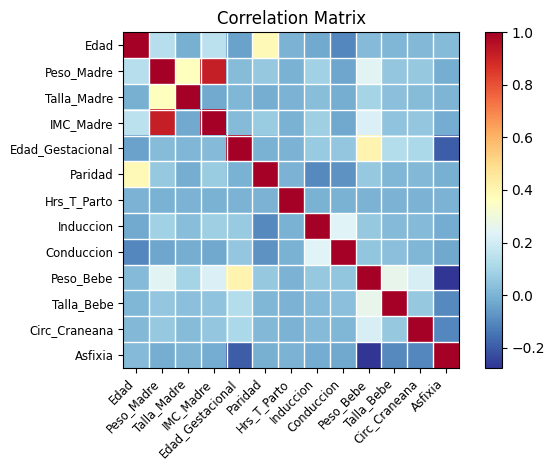

In [32]:
# Se genera una matriz de correlación entre las variables que son conocidas antes del parto y las que pueden tener una estimación
corr= df_partos_modelo.corr()
sm.graphics.plot_corr(corr,xnames=(list(corr.columns)))
plt.show()

# **6. Selección de Variables para reducir la dimensionalidad del dataset.**

> Para seleccionar las variables del modelo, se aplica el método de selección hacia adelante el cual comienza evaluando cada característica individualmente y selecciona aquellas que resulta en el mejor rendimiento para el modelo de algoritmo seleccionado.

> Al aplicar la selección se indentifica que hay diferencias para los distintos algoritmos con que se realiza el ejercicio. Para el modelo de regresión logística, las variables mas importantes son: 'Edad', 'Talla_Madre', 'Edad_Gestacional', 'Paridad', 'Hrs_T_Parto', 'Induccion', 'Circ_Craneana'. Mientras que para random forest son: 'Edad', 'Peso_Madre', 'Talla_Madre', 'IMC_Madre', 'Edad_Gestacional', 'Peso_Bebe', 'Circ_Craneana'.



In [33]:
# Define las columnas a usar en el modelo de regresión logística
X = df_partos_modelo.drop(columns=['Asfixia'])
y = df_partos_modelo['Asfixia']

# Divide el modelo en entrenamiento y testeo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=40)
model = LogisticRegression(max_iter=10000, n_jobs=-1)

# Aplica el método de selección de varibales
selector = RFE(model, n_features_to_select=7)  # Elige el número de características deseadas
selector.fit(X_train, y_train)
selected_features = X_train.columns[selector.support_]

print(selected_features)

Index(['Talla_Madre', 'Edad_Gestacional', 'Paridad', 'Induccion', 'Conduccion',
       'Talla_Bebe', 'Circ_Craneana'],
      dtype='object')


In [34]:
# Define las columnas a usar en el modelo randomforest
X = df_partos_modelo.drop(columns=['Asfixia'])
y = df_partos_modelo['Asfixia']

# Divide el modelo en entrenamiento y testeo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=40)
model_1 = RandomForestClassifier(n_estimators=100, random_state=42)

# Aplica el método de selección de varibales
selector = RFE(model_1, n_features_to_select=8)  # Elige el número de características deseadas
selector.fit(X_train, y_train)
selected_features = X_train.columns[selector.support_]

print(selected_features)

Index(['Edad', 'Peso_Madre', 'Talla_Madre', 'IMC_Madre', 'Edad_Gestacional',
       'Peso_Bebe', 'Talla_Bebe', 'Circ_Craneana'],
      dtype='object')


# **7. Definición de Algoritmo de Clasificación**
Considerando las variables definidas con el método de selección hacía adelante aplicado en el punto anterior, entrenaremos y evaluaremos dos algoritmos de clasificación, un modelo de regresión logística (con 7 variables) y uno de random forest (con 8 variables). Para luego, con base en sus métricas, decidir con cual avanzaremos.

**Conclusiones del modelo**

1. **Exactitud**: Ambos modelos tienen una exactitud muy alta (0.970529), lo que indica que son buenos para predecir tanto casos positivos como negativos.
Precisión: El modelo de regresión logística tiene una precisión ligeramente mayor (0.7895) en comparación con el modelo de random forest (0.7619). Esto significa que el modelo de regresión logística es ligeramente mejor para predecir casos positivos correctamente.
2. **Sensibilidad (Recall)**: Aunque ambos modelos tienen una sensibilidad baja, el modelo de random forest tiene una sensibilidad ligeramente mayor (0.2286) en comparación con el modelo de regresión logística (0.2143). Esto indica que el modelo de random forest es ligeramente mejor para identificar casos positivos.
3. **Especificidad:** Ambos modelos tienen una especificidad muy alta, lo que indica que son excelentes para predecir casos negativos. Sin embargo, el modelo de regresión logística tiene una especificidad ligeramente mayor (0.9979) en comparación con el modelo de random forest (0.9974).
4. **Valor F1:** El valor F1 es una medida que combina precisión y sensibilidad. Aunque ambos modelos tienen un valor F1 bajo, el modelo de random forest tiene un valor F1 ligeramente mayor (0.3516) en comparación con el modelo de regresión logística (0.3371). Esto indica que el modelo de random forest tiene un equilibrio ligeramente mejor entre precisión y sensibilidad.

En resumen, aunque ambos modelos tienen indicadores similares y son aplicables, el modelo de regresión logística tiene una precisión y especificidad ligeramente mayores, mientras que el modelo de random forest tiene una sensibilidad y un valor F1 ligeramente mayores.

In [35]:
# Define las columnas a usar en el modelo de regresión logística
X = df_partos_modelo[['Edad', 'Talla_Madre', 'Edad_Gestacional', 'Paridad', 'Induccion', 'Conduccion', 'Circ_Craneana']]
y = df_partos_modelo['Asfixia']

# Divide el modelo en entrenamiento y testeo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=40)

# Define modelo de algoritmo de clasificación
Modelo_0 = LogisticRegression(max_iter=10000, n_jobs=-1)

# Ajusta el modelo con los datos de entrenamiento
Modelo_0.fit(X_train, y_train)

# Genera predicciones con los datos de testeo
predicciones = Modelo_0.predict(X_test)

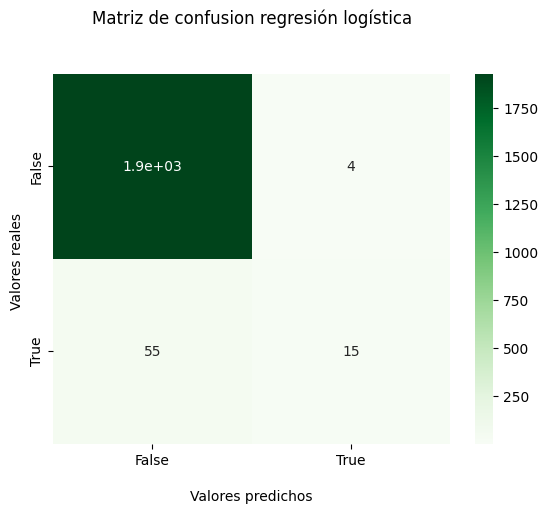

Exactitud: 0.970529
Precisión: 0.7895
Sensibilidad (Recall): 0.2143
Especificidad: 0.9979
Valor F1: 0.3371


In [36]:
#Matriz de confusion
cf_matrix = confusion_matrix(y_test, predicciones)

ax = sns.heatmap(cf_matrix, annot=True, cmap='Greens')
ax.set_title('Matriz de confusion regresión logística\n\n');
ax.set_xlabel('\nValores predichos')
ax.set_ylabel('Valores reales ');
## Ticket labels - En orden alfabetico
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
plt.show()

from sklearn.metrics import recall_score, precision_score, f1_score

# Calcula las métricas
exactitud = accuracy_score(y_test, predicciones)
precision = precision_score(y_test, predicciones)
sensibilidad = recall_score(y_test, predicciones)
especificidad = cf_matrix[0, 0] / (cf_matrix[0, 0] + cf_matrix[0, 1])
valor_f1 = f1_score(y_test, predicciones)

print(f"Exactitud: {exactitud:4f}")
print(f"Precisión: {precision:.4f}")
print(f"Sensibilidad (Recall): {sensibilidad:.4f}")
print(f"Especificidad: {especificidad:.4f}")
print(f"Valor F1: {valor_f1:.4f}")

In [37]:
# Define las columnas a usar en el modelo random forest
X = df_partos_modelo[['Edad', 'Peso_Madre', 'Talla_Madre', 'IMC_Madre', 'Edad_Gestacional', 'Peso_Bebe', 'Talla_Bebe', 'Circ_Craneana']]
y = df_partos_modelo['Asfixia']

# Divide el modelo en entrenamiento y testeo
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.25, random_state=40)

# Define modelo de algoritmo de clasificación
Modelo_rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Ajusta el modelo con los datos de entrenamiento
Modelo_rf.fit(X_train, y_train)

# Genera predicciones con los datos de testeo
predicciones_rf = Modelo_rf.predict(X_test)

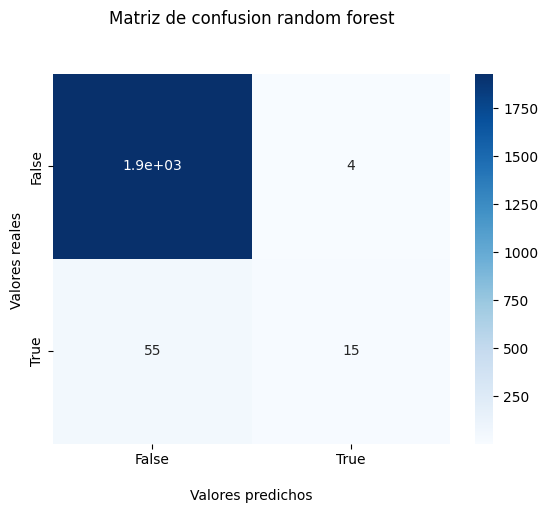

Exactitud: 0.970529
Precisión: 0.7619
Sensibilidad (Recall): 0.2286
Especificidad: 0.9974
Valor F1: 0.3516


In [38]:
#Matriz de confusion
cf_matrix2 = confusion_matrix(y_test, predicciones_rf)

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')
ax.set_title('Matriz de confusion random forest\n\n');
ax.set_xlabel('\nValores predichos')
ax.set_ylabel('Valores reales ');
## Ticket labels - En orden alfabetico
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
plt.show()

# Calcula las métricas
exactitud1 = accuracy_score(y_test, predicciones_rf)
precision1 = precision_score(y_test, predicciones_rf)
sensibilidad1 = recall_score(y_test, predicciones_rf)
especificidad1 = cf_matrix2[0, 0] / (cf_matrix2[0, 0] + cf_matrix2[0, 1])
valor_f1_1 = f1_score(y_test, predicciones_rf)

print(f"Exactitud: {exactitud1:4f}")
print(f"Precisión: {precision1:.4f}")
print(f"Sensibilidad (Recall): {sensibilidad1:.4f}")
print(f"Especificidad: {especificidad1:.4f}")
print(f"Valor F1: {valor_f1_1:.4f}")

# **8. Evaluación del Modelo de ML**
A continuación se evalua el ajuste que tiene el modelo de regresión logística, para esto se usan dos gráficas de la curva de aprendizaje (Naive Bayes y Support Vector Machine), en ambas se presentan dos curvas, una para el rendimiento del conjunto de entrenamiento y otra para el conjunto de prueba. Ademas se presentan las metricas analizadas en el punto anterior.

Todo lo anterior, para conocer si nuestro modelo presenta problemas de overfitting o underfitting.

**Conclusiones del modelo**

1. Los gráficos muestran que a medida que aumenta la cantidad de datos disminuye la brecha de exactitud de los datos de entrenamiento y prueba, lo que indica que nuestro modelo generaliza bien y no presenta problemas de ajuste

2. Sin embargo, la baja sensibilidad y el valor F1 de 0.33 indican que el modelo necesita mejorar su capacidad para detectar casos positivos sin comprometer la precisión.

**En resumen**, el modelo generaliza bien pero, aún con los nuevos datos,  debe mejorar la capacidad de detección de casos positivos pudiendo ser necesario ajustar el umbral de clasificación o alimentar con más datos para mejorar la sensibilidad sin comprometer la precisión.

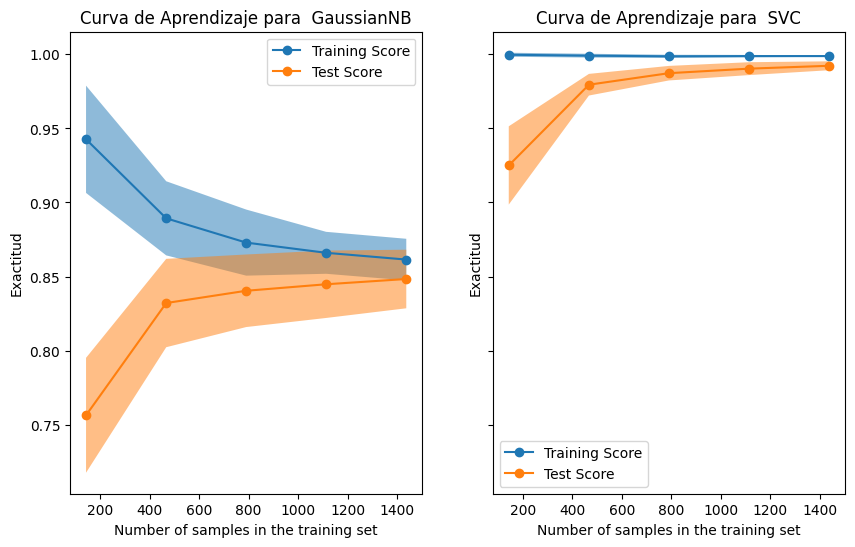

Exactitud: 0.970529
Precisión: 0.7895
Sensibilidad (Recall): 0.2143
Especificidad: 0.9979
Valor F1: 0.3371


In [39]:
X, y = load_digits(return_X_y=True)
naive_bayes = GaussianNB()
svc = SVC(kernel="rbf", gamma=0.001)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 6), sharey=True)
common_params = {
    "X": X,
    "y": y,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": ShuffleSplit(n_splits=50, test_size=0.2, random_state=0),
    "score_type": "both",
    "n_jobs": 4,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "Exactitud",
}

for ax_idx, estimator in enumerate([naive_bayes, svc]):
    LearningCurveDisplay.from_estimator(estimator, **common_params, ax=ax[ax_idx])
    handles, label = ax[ax_idx].get_legend_handles_labels()
    ax[ax_idx].legend(handles[:2], ["Training Score", "Test Score"])
    ax[ax_idx].set_title(f"Curva de Aprendizaje para  {estimator.__class__.__name__}")

plt.show()

# Calcula las métricas
exactitud = accuracy_score(y_test, predicciones)
precision = precision_score(y_test, predicciones)
sensibilidad = recall_score(y_test, predicciones)
especificidad = cf_matrix[0, 0] / (cf_matrix[0, 0] + cf_matrix[0, 1])
valor_f1 = f1_score(y_test, predicciones)

print(f"Exactitud: {exactitud:4f}")
print(f"Precisión: {precision:.4f}")
print(f"Sensibilidad (Recall): {sensibilidad:.4f}")
print(f"Especificidad: {especificidad:.4f}")
print(f"Valor F1: {valor_f1:.4f}")

# **9. Anexo API's**

A continuación se presenta un anexo de uso de API, dado que no fue posible encontrar una API publica y gratuita relacionada al tema de este proyecto, se utiliza una con tematica de videojuegos obtenida en [kaggle](https://https://www.kaggle.com/datasets/skateddu/metacritic-all-time-games-stats) y subida a un repositorio de [github](https://github.com/Fsayes/Steam/blob/main/metacritic_games.json)

In [40]:
# Se importan las librerias y se otorga el vinculo de la API

import requests
import json

url='https://raw.githubusercontent.com/Fsayes/Steam/main/metacritic_games.json?token=GHSAT0AAAAAACQ6HWSYLPNZI7HVWKDKIOEMZQ4LLAQ'
respuesta = requests.get(url)
print(respuesta)

<Response [200]>


In [41]:
# se procesa los datos obtenidos de la API con pandas
texto = respuesta.text
jsondata = json.loads(texto)
df_json = pd.DataFrame.from_dict(jsondata)

df_json.shape

(20422, 18)

In [42]:
# Realizar transformaciones en el datasetde la API para resumir y obtener insights

# Transformar el campo release_date en fecha
df_json['release_date'] = pd.to_datetime(df_json['release_date'])

# Crear nuevas columnas para el mes y el año
df_json['month'] = df_json['release_date'].dt.month
df_json['year'] = df_json['release_date'].dt.year

df_json.columns

Index(['name', 'platform', 'developer', 'publisher', 'genre(s)', 'players',
       'rating', 'attribute', 'release_date', 'link', 'critic_positive',
       'critic_neutral', 'critic_negative', 'metascore', 'user_positive',
       'user_neutral', 'user_negative', 'user_score', 'month', 'year'],
      dtype='object')

In [43]:
# Titulos con mayor metascore por cada plataforma

# Agrupar por plataforma y encontrar el título con el mayor metascore en cada plataforma
top_titles = df_json.loc[df_json.groupby('platform')['metascore'].idxmax()]

# Imprimir los títulos con el mayor metascore en cada plataforma
print(top_titles[['name', 'platform', 'metascore']])

                                          name platform  metascore
10321  The Legend of Zelda: Ocarina of Time 3D      3DS         94
108                                SoulCalibur       DC         98
8046          Grand Theft Auto: Chinatown Wars       DS         93
592                   Tony Hawk's Pro Skater 2      GBA         95
1215                             Metroid Prime       GC         97
61        The Legend of Zelda: Ocarina of Time      N64         99
63                                   Half-Life       PC         96
162                   Tony Hawk's Pro Skater 2       PS         98
587                   Tony Hawk's Pro Skater 3      PS2         97
6933                       Grand Theft Auto IV      PS3         98
13399                       Grand Theft Auto V      PS4         97
6949             God of War: Chains of Olympus      PSP         91
17158  The Legend of Zelda: Breath of the Wild   Switch         97
11387                         Persona 4 Golden     VITA       

**Resumen Gráfico del dataset**

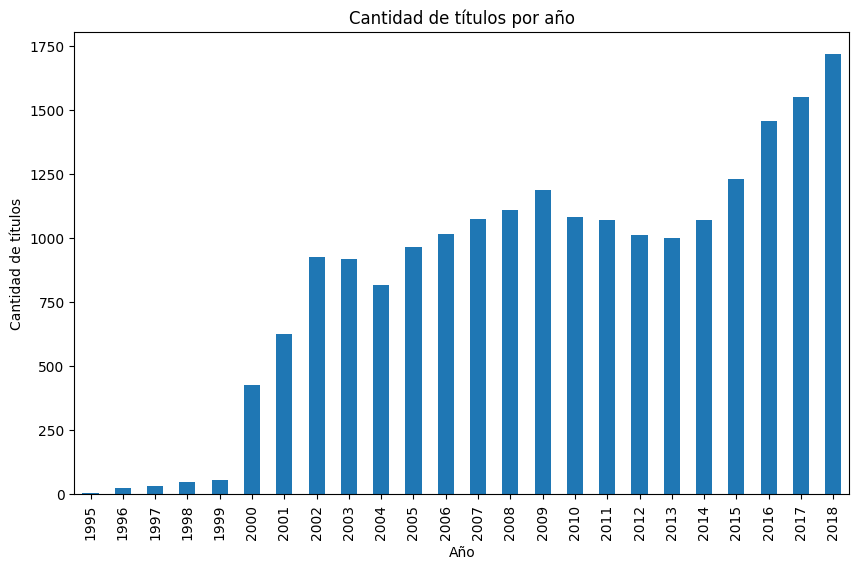

In [44]:
# Cantidad de títulos por año
plt.figure(figsize=(10,6))
df_json['year'].value_counts().sort_index().plot(kind='bar')
plt.title('Cantidad de títulos por año')
plt.xlabel('Año')
plt.ylabel('Cantidad de títulos')
plt.show()

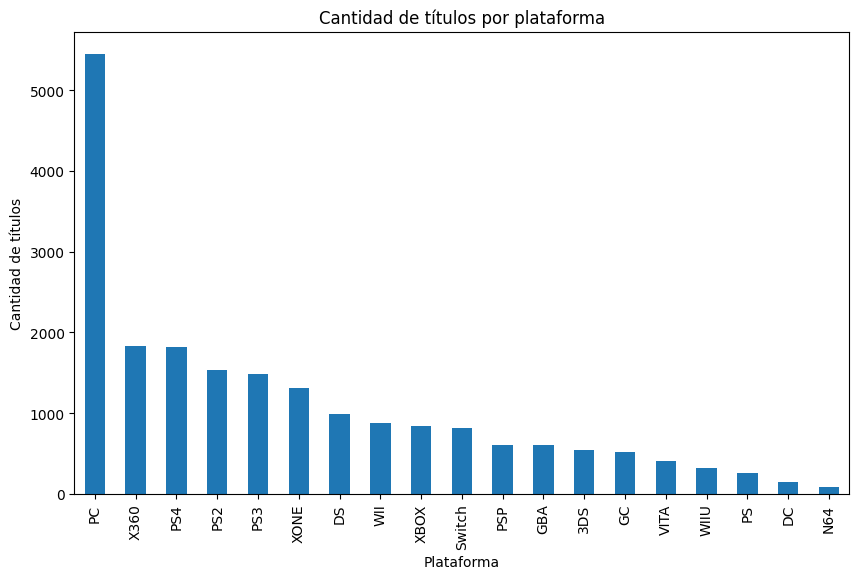

In [45]:
# Cantidad de títulos por plataforma
plt.figure(figsize=(10,6))
df_json['platform'].value_counts().plot(kind='bar')
plt.title('Cantidad de títulos por plataforma')
plt.xlabel('Plataforma')
plt.ylabel('Cantidad de títulos')
plt.show()

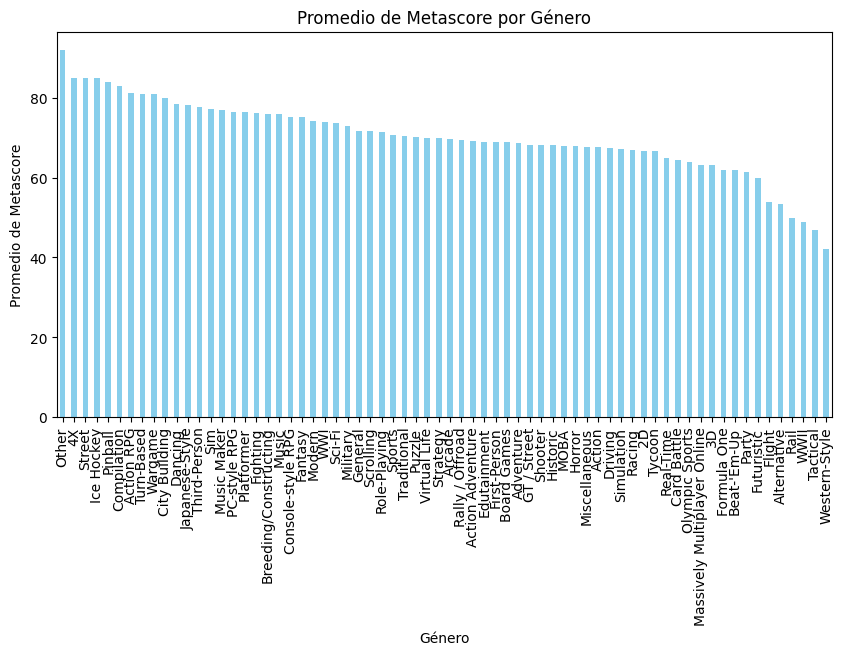

In [46]:
# Generos con mayor metascore

# Agrupamos por género y calculamos el promedio de metascore
resumen_metascore = df_json.groupby('genre(s)')['metascore'].mean().sort_values(ascending=False)

# Creamos el gráfico
plt.figure(figsize=(10,5))
resumen_metascore.plot(kind='bar', color='skyblue')
plt.title('Promedio de Metascore por Género')
plt.xlabel('Género')
plt.ylabel('Promedio de Metascore')
plt.show()